# What is DQN?
So I asked my friend GPT to explain DQN to a person who only knows about linear approximators, and here is what I found.  

Instead of hand-crafting features using tile coding or making them by ourselves, why not let the deep neural network learn them?  
DQN (Deep Q-Network) approximates the Q-functions instead of storing Q-values like tabular Q-Learning.

# Why go with DQN?
Now we were struggling with making features using either tile coding or making the features ourselves. We do not have enough time before submission to make the features ourselves. Results and analysis are needed.   
Therefore, we are going to use the help of DRL by using CNN (Convolutional Neural Network) for image processing and DQN to approximate whatever we get from CNN.  
Also 2 of our team members took Machine Learning, so we are a bit familiar with CNN.  
We are hoping for less training time so we can test on different alphas, gammas, and maybe rewards. 

In [4]:
# First lets work on making the CNN
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import cv2
from collections import deque

Here are explanations for the numbers we are using for the CNN model:
- Fitlers: 
    For filters we are going with 32, 64, 64 as it is a very common setup for CNN. We start 32 to detect edges and shapes. Then, going 64 fitlers twice to detect more complex shapes.
- Kernel size:
    For kernel size we start with a big enough size of 8x8 matrix that slides through the images. Calculation and operations are done to detect features. Then we decrease it to 4x4, and end with 3x3.
- Strides:
    Strides determine how far we move each time. We start with a big one 4, which aggressibely reduces spacial size. Then, 2 to further downsample it. Finally, we end with one stride 

In [5]:
# Define the CNN model
def create_cnn_model(input_shape, num_actions):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # Rescaling is for normalizing the pixel values to be between 0 and 1
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, kernel_size=8, strides=4, activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, activation="relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        # For DQN we dont need to use activation function
        tf.keras.layers.Dense(num_actions)
    ])
    return model


In [6]:
# helper classes and functions for DQN

# Replay Buffer for DQN
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def ready(self, batch_size):
        return len(self.buffer) >= batch_size
    
# Preprocess the image
def preprocess(image):
    image = cv2.resize(image, (96, 96))
    return image

# Train step
@tf.function
def train_step(model, target_model, optimizer, states, actions, rewards, next_states, dones, gamma):
    future_q = tf.reduce_max(target_model(next_states), axis=1)
    target_q = rewards + (1.0 - dones) * gamma * future_q
    with tf.GradientTape() as tape:
        q_values = tf.reduce_sum(model(states) * tf.one_hot(actions, model.output_shape[-1]), axis=1)
        loss = tf.keras.losses.MSE(target_q, q_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [7]:
class DQNAgent:
    def __init__(self, input_shape, num_actions, alpha=0.1, gamma=0.9,
                 epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995,
                 batch_size=64, buffer_size=100_000, target_update_freq=1000):
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.steps = 0

        self.policy_net = create_cnn_model(input_shape, num_actions)
        self.target_net = create_cnn_model(input_shape, num_actions)
        self.target_net.set_weights(self.policy_net.get_weights())

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
        self.buffer = ReplayBuffer(buffer_size)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state_input = np.expand_dims(state, axis=0)
        q_values = self.policy_net.predict(state_input, verbose=0)
        return np.argmax(q_values)

    def store_experience(self, experience):
        self.buffer.add(experience)

    def update_target_network(self):
        self.target_net.set_weights(self.policy_net.get_weights())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self):
        if not self.buffer.ready(self.batch_size):
            return
        batch = self.buffer.sample(self.batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        train_step(
            self.policy_net, self.target_net, self.optimizer,
            tf.convert_to_tensor(s, dtype=tf.float32),
            tf.convert_to_tensor(a, dtype=tf.int32),
            tf.convert_to_tensor(r, dtype=tf.float32),
            tf.convert_to_tensor(s2, dtype=tf.float32),
            tf.convert_to_tensor(d, dtype=tf.float32),
            self.gamma
        )
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.update_target_network()

    def run_episode(self, env):
        obs, _ = env.reset()
        state = preprocess(obs)
        done, total_reward = False, 0

        while not done:
            action = self.select_action(state)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess(next_obs)
            self.store_experience((state, action, reward, next_state, float(done)))
            self.train()
            state = next_state
            total_reward += reward

        self.decay_epsilon()
        return total_reward




Episode 1 finished with reward -56.810631229236726
Episode 2 finished with reward -58.083832335330186
Episode 3 finished with reward -51.492537313433665
Episode 4 finished with reward -56.386292834891805
Episode 5 finished with reward -60.91205211726474
Episode 6 finished with reward -57.928802588997605
Episode 7 finished with reward -54.703832752614026
Episode 8 finished with reward -59.73154362416197
Episode 9 finished with reward -53.020134228188766
Episode 10 finished with reward -48.00000000000069
Episode 11 finished with reward -58.199356913184076
Episode 12 finished with reward -56.22895622895705
Episode 13 finished with reward -54.24836601307264
Episode 14 finished with reward -61.937716262976636
Episode 15 finished with reward -52.7272727272735
Episode 16 finished with reward -52.21843003413058
Episode 17 finished with reward -54.83870967742016
Episode 18 finished with reward -61.90476190476276
Episode 19 finished with reward -49.806949806950634
Episode 20 finished with rewar

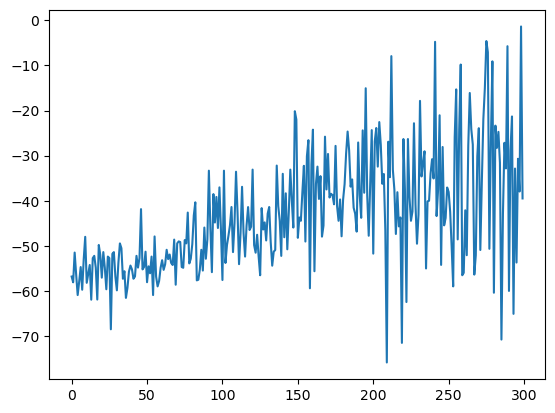

In [8]:
def main():
    num_episodes = 300
    # Define the environment
    env = gym.make("CarRacing-v3", continuous=False)
    action_space = env.action_space.n
    state_space = env.observation_space.shape
    agent = DQNAgent(state_space, action_space)

    rewards = []
    for episode in range(num_episodes):
        total_reward = agent.run_episode(env)
        rewards.append(total_reward)
        print(f"Episode {episode + 1} finished with reward {total_reward}")

    plt.plot(rewards)
    plt.show()

if __name__ == "__main__":
    main()


In [9]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs:", tf.config.list_physical_devices("GPU"))


TF Version: 2.15.0
Built with CUDA: False
GPUs: []
